# Sentinel-1 Data

This notebook aims to test some Data Cube functions using Sentinel-1 data

First... we do all the necessary imports !

In [1]:
%matplotlib inline
# necessary for plot display in jupyter

from datetime import date
import json
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
#import ogr
#import pandas
from datacube.api.model import DatasetType, Satellite, BANDS
from datacube.api.query import list_tiles_as_list
from datacube.api.utils import get_dataset_data, get_dataset_metadata
from eotools.tiling import generate_tiles
from eotools.coordinates import convert_coordinates
from idl_functions import histogram
from math import log10
#from idl_functions import hist_equal
#from idl_functions import label_region
#from image_processing.segmentation import SegmentVisitor

In [21]:
import sys

def my_print(text):
    sys.stdout.write(str(text))
    sys.stdout.flush()

We define all the parameters we want to retrieve the data

In [3]:
dataset_types = [DatasetType.SIGMA_VV]
min_date = date(2015, 01, 01)
max_date = date(2015, 12, 31)
satellites = [Satellite(i) for i in ['S1']]
x_cell = [88,89,90,91]
y_cell = [25,26]

We request the tiles according to the parameters and we check that we have the 6 tiles corresponding to our Landsat image

In [4]:
tiles = list_tiles_as_list(x=x_cell, y=y_cell, acq_min=min_date,
                           acq_max=max_date,
                           satellites=satellites,
                           dataset_types=dataset_types)

In [5]:
print "Number of time periods: {}".format(len(tiles))

Number of time periods: 8


In [6]:
def getDatasetFromTile(tile):
    dataset = tile.datasets[DatasetType.SIGMA_VV]
    data = get_dataset_data(dataset)
    metadata = get_dataset_metadata(dataset)
    samples, lines = metadata.shape
    print "Tile file path location: {path}".format(path=dataset.path)
    print "Array dimensions:\nx: {x} & y: {y}".format(x=samples, y=lines)
    return data

In [7]:
data = getDatasetFromTile(tiles[2])

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


In [8]:
def showDataset(data):
    matrix = np.reshape(data.get(data.keys()[0]), (-1, 4000))
    plt.imshow(matrix, cmap = cm.Greys_r, vmin=0, vmax=1)
    plt.colorbar()    

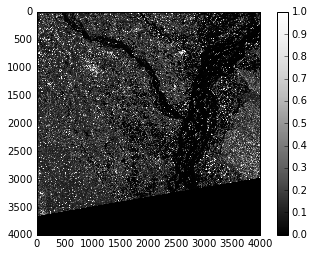

In [9]:
showDataset(data)

In [10]:
print "Min",data.get(data.keys()[0]).min()
print "Max",data.get(data.keys()[0]).max()

Min -28672.0
Max 241.925


In [11]:
def getLogFilteredNoDataAndZeros(data):
    allVal = []
    for tab in data.get(data.keys()[0]):
        for val in tab:
            if val > 0:
                allVal.append(log10(val))
    return allVal

In [12]:
allVal = getLogFilteredNoDataAndZeros(data)

In [13]:
def showHistogram(data):
    (n, bins) = np.histogram(data, bins=100, range=[-3,3])  # NumPy version (no plot)
    plt.figure()
    plt.plot(.5*(bins[1:]+bins[:-1]), n)
    plt.show()
    plt.close()

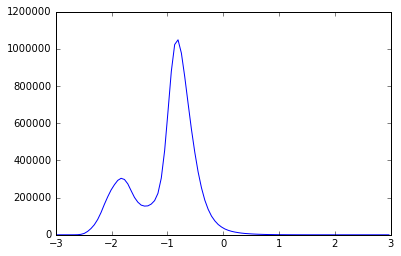

In [14]:
showHistogram(allVal)

In [15]:
import time
import numpy
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import interpolate
from scipy import signal

In [27]:
def bimodalHistDetection(imageFlatenned, nbOfMiniIntervals, stdFiltering):
    minval= numpy.min(imageFlatenned) 
    maxval= numpy.max(imageFlatenned)
    meanval = numpy.mean(imageFlatenned)
    stddevval = numpy.std(imageFlatenned)
    print 'Min Val:',minval
    print 'Max Val:',maxval
    print 'Mean Val:',meanval
    print 'Std dev Val:',stddevval
    
    tabX = numpy.linspace(minval, maxval, 256)
    tabY = numpy.arange(256)
    
    finterp1 = interpolate.interp1d(tabX,tabY,kind='nearest')
    finterp2 = interpolate.interp1d(tabY,tabX,kind='linear')
    newValues = finterp1(imageFlatenned) 
        
    hist, bins = numpy.histogram(newValues, bins=256, range=(0,255))
    
    xs = numpy.arange(len(hist))
    xss = finterp2(xs)
    # plt.bar(xs, hist, color="black")
    # print 'XSSS',xss
    
    window = signal.gaussian(51, std = stdFiltering)
    hist_filtered = numpy.convolve(hist, window/window.sum(),mode='same')
    
    hist_filtered_interp = interpolate.interp1d(xss,hist_filtered,kind='linear')
    
    funct = lambda xss : hist_filtered_interp(xss)
    funct_neg = lambda xss : -hist_filtered_interp(xss)
    
    eps = 1.e-4
    delta = (maxval - minval)/nbOfMiniIntervals 
    delta = delta - (delta/1000.) 
    
    #Trouver les xmin des minimas en faisant une boucle sur des intervalles consecutives sur toute la plage de variation 
    tabValMin = []
    tabValMax = []
    
    bmin = minval
    for i in range(nbOfMiniIntervals):
        bmax = bmin + delta
        # print 'bmin',bmin
        # print 'bmax',bmax
        xmin = optimize.fminbound(funct, bmin, bmax)
        xmax = optimize.fminbound(funct_neg, bmin, bmax)
        if (numpy.abs(xmin - bmin) > eps and numpy.abs(xmin - bmax) > eps):
            tabValMin.append(xmin)
        if (numpy.abs(xmax - bmin) > eps and numpy.abs(xmax - bmax) > eps):
            tabValMax.append(xmax)
        bmin = bmax
    
    f_minval = numpy.min(hist_filtered_interp(xss))
    f_maxval = numpy.max(hist_filtered_interp(xss))
    total_f_variation = numpy.abs(f_maxval - f_minval)
    
    tabValMin = numpy.array(tabValMin)
    tabValMax = numpy.array(tabValMax)
        
    if numpy.size(tabValMin) != 0 and numpy.size(tabValMax) != 0:    
        f_tabValMin = funct(tabValMin)
        max_f_tabValMin = numpy.max(f_tabValMin)
        f_tabValMax = funct(tabValMax)
        min_f_tabValMax = numpy.min(f_tabValMax)
        
        local_f_min_variation = numpy.abs(min_f_tabValMax - max_f_tabValMin)
    
        sharpness = (local_f_min_variation/total_f_variation)*100
        
    else:
        tabValMin = []
        sharpness = 0
        tabValMin.append(40)
        tabValMin = numpy.array(tabValMin)
        f_tabValMin = 40
    
    return sharpness,tabValMin,f_tabValMin

In [28]:
def computeThresholdOnPreprocessedTile(tablin, nbOfMiniIntervals = 20, stdFiltering = 3.5, sharpnessLimit=5.0): 
    nantest = numpy.where(numpy.isnan(tablin), 1, 0)
    zerotest = numpy.where(tablin == 0, 1, 0)
    # print 'Number of NaN',numpy.sum(nantest)
    # print 'Number of Zero',numpy.sum(zerotest)
    min_tab_min = []
    sharpness = 0
        
    if (numpy.sum(nantest) == 0):
        if (numpy.sum(zerotest) == 0):
            sharpness, tabmin, f_tabmin = bimodalHistDetection(tablin, nbOfMiniIntervals, stdFiltering)
            if sharpness > sharpnessLimit:
                min_tab_min.append(numpy.min(tabmin))

    return sharpness, min_tab_min

In [29]:
sharpness, min_tab_min = computeThresholdOnPreprocessedTile(allVal)
print sharpness
print min_tab_min
print pow(10,min_tab_min[0])

Min Val: -2.7829867526
Max Val: 2.3836807552
Mean Val: -1.02816907214
Std dev Val: 0.536839021887
13.5531732001
[-1.3849478693445947]
0.0412146988303


Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/088_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


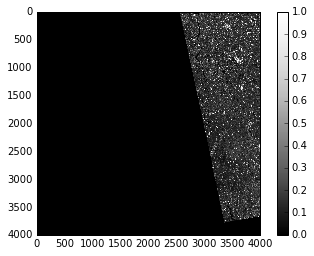

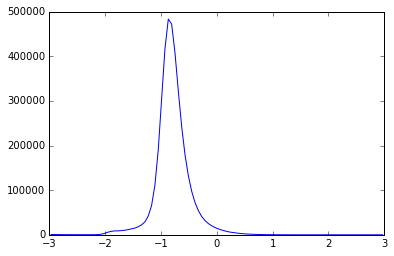

Min Val: -4.83824074322
Max Val: 2.25117268372
Mean Val: -0.835071837892
Std dev Val: 0.446564914703
No threshold found.
Sharpness: 0.841363673417

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/088_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_088_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


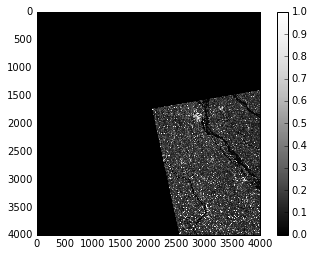

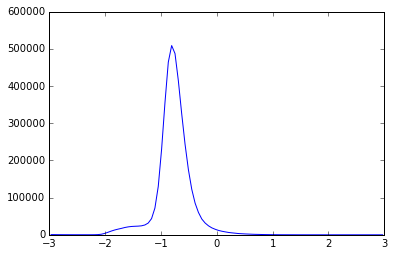

Min Val: -4.54275340811
Max Val: 1.92861419288
Mean Val: -0.801556280512
Std dev Val: 0.407419123743
No threshold found.
Sharpness: 0.597030894125

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/089_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


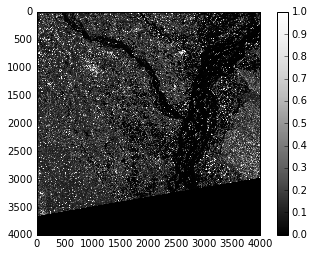

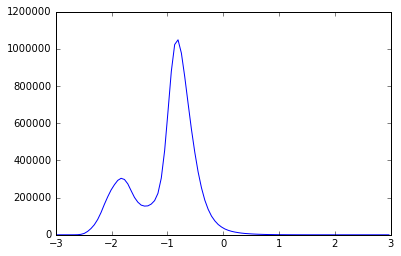

Min Val: -2.7829867526
Max Val: 2.3836807552
Mean Val: -1.02816907214
Std dev Val: 0.536839021887
Threshold: -1.38494786934
Sharpness: 13.5531732001

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/089_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_089_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


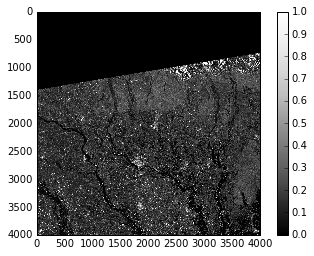

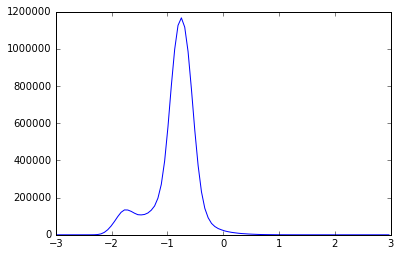

Min Val: -2.53357200153
Max Val: 2.15379589033
Mean Val: -0.851265023873
Std dev Val: 0.378389662582
No threshold found.
Sharpness: 1.83558287606

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/090_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


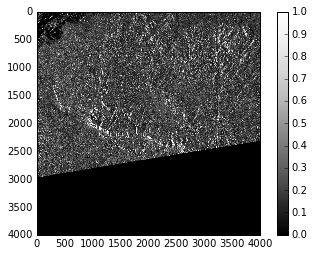

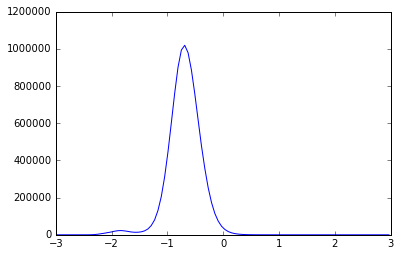

Min Val: -2.492432995
Max Val: 1.8741156052
Mean Val: -0.697502370251
Std dev Val: 0.297357830358
No threshold found.
Sharpness: 1.44672384349

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/090_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_090_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


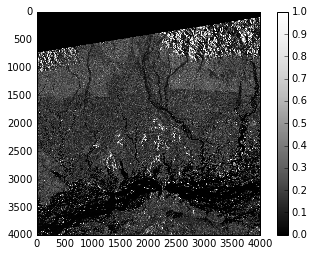

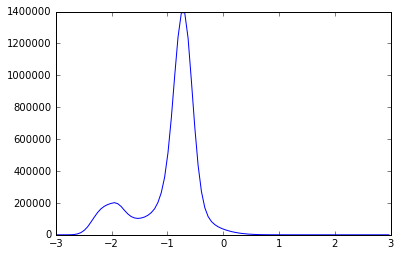

Min Val: -2.88709874037
Max Val: 1.98412677336
Mean Val: -0.945536748956
Std dev Val: 0.526389123522
Threshold: -1.53079579446
Sharpness: 6.83094752009

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/091_025/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_025_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


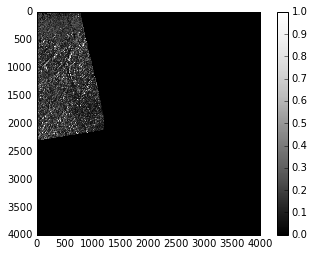

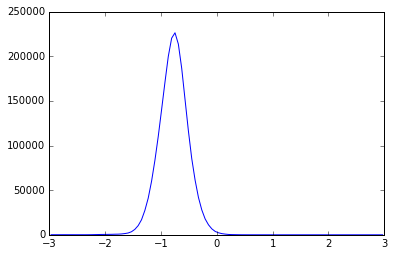

Min Val: -5.20023145977
Max Val: 1.46832109287
Mean Val: -0.77811567137
Std dev Val: 0.266054276106
No threshold found.
Sharpness: 0.0372478113054

##########

Tile file path location: /data/agdc/internal/tiles/SENTINEL/S1_Sentinel_1/091_026/2015/S1_Sentinel_1_RANGE_DOPPLER_TERRAIN_CORRECTION_091_026_2015-09-02T12-04-44.594384.tif
Array dimensions:
x: 4000 & y: 4000


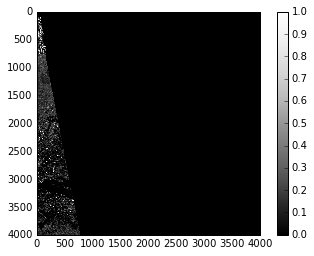

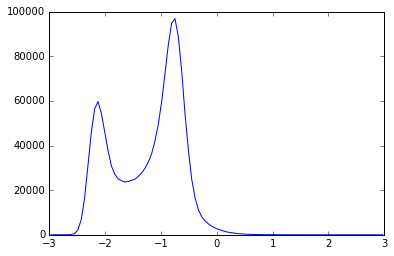

Min Val: -6.96885188705
Max Val: 2.58509518902
Mean Val: -1.24438647484
Std dev Val: 0.623284470888
Threshold: -6.18205954331
Sharpness: 30.5723469619

##########

Finished handling tiles.


In [30]:
thresholds = []
for tile in tiles:
    tileDataset = getDatasetFromTile(tile)
    showDataset(tileDataset)
    filteredData = getLogFilteredNoDataAndZeros(tileDataset)
    showHistogram(filteredData)
    sharpness, value = computeThresholdOnPreprocessedTile(filteredData)
    if len(value) > 0:
        thresholds.append(value[0])
        my_print("Threshold: {0}\n".format(value[0]))
    else:
        my_print("No threshold found.\n")
    my_print("Sharpness: {0}\n".format(sharpness))
    my_print("\n")
    my_print("##########\n")
    my_print("\n")
print "Finished handling tiles."

In [33]:
min_tab_min = thresholds
nbOfSplitNeeded = len(min_tab_min)
min_tab_min = numpy.array(min_tab_min)

print
print 'nbOfSplitNeeded',nbOfSplitNeeded
print

min_val = numpy.min(min_tab_min)
max_val = numpy.max(min_tab_min)

tabX = numpy.linspace(numpy.min(min_tab_min), numpy.max(min_tab_min), 256)
tabY = numpy.arange(256)
finterp1 = interpolate.interp1d(tabX,tabY,kind='nearest')
finterp2 = interpolate.interp1d(tabY,tabX,kind='linear')
newValues = finterp1(min_tab_min) 


hist, bins = numpy.histogram(newValues, bins=256, range=(0,255))

xs = numpy.arange(len(hist))
xss = finterp2(xs)

window = signal.gaussian(51, std = 1)
hist_filtered = numpy.convolve(hist, window/window.sum(),mode='same')
hist_filtered_interp = interpolate.interp1d(xss,hist_filtered,kind='linear')
hist_filtered_tab = hist_filtered_interp(xss)

for i in range(len(xss)):
    if (hist_filtered_tab[i] != 0):
        minSeuil = xss[i]
        break


funct = lambda xss : hist_filtered_interp(xss)
funct_neg = lambda xss : -hist_filtered_interp(xss)
    
nbOfIntervals = 60
eps = 1.e-4
delta = (max_val - min_val)/nbOfIntervals

#Trouver les xmin des minimas en faisant une boucle sur des intervalles consecutives sur toute la plage de variation 
tabValMin = []
tabValMax = []

bmin = min_val
for i in range(nbOfIntervals):
    bmax = bmin + delta
    xmin = optimize.fminbound(funct, bmin, bmax)
    xmax = optimize.fminbound(funct_neg, bmin, bmax)
    if (numpy.abs(xmin - bmin) > eps and numpy.abs(xmin - bmax) > eps):
        tabValMin.append(xmin)
    if (numpy.abs(xmax - bmin) > eps and numpy.abs(xmax - bmax) > eps):
        tabValMax.append(xmax)
    bmin = bmax
                        
tabValMin = numpy.array(tabValMin)
tabValMax = numpy.array(tabValMax)

f_tabValMin = funct(tabValMin)
f_tabValMax = funct(tabValMax)

print '###########################################'
print thresholds
print tabValMin
print tabValMax
print '###########################################'
print 'VALEUR DU PREMIER SEUIL:',tabValMax[numpy.where(f_tabValMax == numpy.max(f_tabValMax))],tabValMax[0]
f_tabValMax[numpy.where(f_tabValMax == numpy.max(f_tabValMax))] = 0.
print 'VALEUR DU DEUXIEME SEUIL:',tabValMax[numpy.where(f_tabValMax == numpy.max(f_tabValMax))],tabValMax[1]

print
print 'SEUIL 1:', (tabValMax[0] + tabValMax[1])/2.
print 'SEUIL 2:', (minSeuil + tabValMax[0])/2.
print
print '&&&&&&&&&&&&&&&&&&&'
print 'minSeuil:', minSeuil
print
print  '------------------------------------------------'
print  'SEUIL :', (tabValMax[0] + tabValMax[1])/2.
print  '------------------------------------------------'
print

plt.plot(xss, hist, color="black")
plt.plot(xss,hist_filtered_tab, color="red")
plt.plot(tabValMax,funct(tabValMax),'ro')
plt.show()




nbOfSplitNeeded 3

###########################################
[-1.3849478693445947, -1.5307957944630373, -6.1820595433096583]
[-1.46019711]
[-1.53544352]
###########################################
VALEUR DU PREMIER SEUIL: [-1.53544352] -1.53544352497
VALEUR DU DEUXIEME SEUIL: [-1.53544352]

IndexError: index 1 is out of bounds for axis 0 with size 1